In [4]:
!pip install POT
!pip install ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from google.colab import files
from matplotlib import animation
from IPython.display import HTML
import ot
import time

In [6]:
def clamp(value, min_val, max_val):
    return np.maximum(min_val, np.minimum(value, max_val))

In [7]:
def sdf_box(p, b=[0.7,0.7]):
    p = p.copy()
    d = np.abs(x)-b
    max_d = np.maximum(d, 0.0)
    length_d = np.sqrt(np.sum(max_d**2, 1))
    return length_d + np.minimum(np.maximum(d[:,0], d[:,1]), 0.0)

In [23]:
def sdf_pentagon(p,r=0.7):
    p = p.copy()
    k = np.array([0.809016994,0.587785252,0.726542528]);
    p[:,0] = np.abs(p[:,0])
    p[:,1] = -p[:,1]
    l = np.array([-k[0],k[1]])
    m = np.array([k[0],k[1]])
    q = 2.0 * np.minimum(np.dot(p, l), 0.0)
    p[:,0] -= q * l[0]
    p[:,1] -= q * l[1]
    q = 2.0 * np.minimum(np.dot(p, m), 0.0)
    p[:,0] -= q * m[0]
    p[:,1] -= q * m[1]
    p[:,0]-=clamp(p[:, 0],-r*k[2],r*k[2])
    p[:,1]-=r
    return np.linalg.norm(p,axis=1)*np.sign(p[:,1])

In [9]:
def translate(x_in, v_t):
    x_out = x_in - v_t
    return x_out

In [10]:
def sdf_small_translated_box(x):
    v = np.array([0.5,0.5])
    x_out = translate(x, v)
    return sdf_box(x_out, b=[0.5,0.5])

In [11]:
def sdf_small_translated_pentagon(x):
    v = np.array([-1.0,-1.0])
    x_out = translate(x, v)
    return sdf_pentagon(x_out,r=0.5)

In [12]:
def gen_grid(resolution, low=-1.0, high=1.0):
    idx = np.linspace(low, high, num=resolution)
    x, y = np.meshgrid(idx, idx)
    V = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), 1)

    return V

In [13]:
def r_union(f1, f2):
    return f1 + f2 + np.sqrt(f1**2 + f2**2)

In [14]:
def r_intersection(f1, f2):
    return f1 + f2 - np.sqrt(f1**2 + f2**2)

In [15]:
def linear_morphing(f1, f2, t, x):
    return (1-t)*f1(x) + t*f2(x)

In [16]:
def space_time_blending(f1, f2, t, x, a0=1.0, a1=1.0, a2=1.0):
    f1x = f1(x)
    f2x = f2(x)

    #f1x_cyl = np.minimum(f1x, -t) # needs R-functions to work properly
    f1x_cyl = r_intersection(f1x, -t)
    #f2x_cyl = np.minimum(f2x, (t-1)) # needs R-functions to work properly
    f2x_cyl = r_intersection(f2x, (t-1))

    disp = a0 / (1.0 + (f1x_cyl/a1)**2 + (f2x_cyl/a2)**2)
    r_uni = r_union(f1x_cyl, f2x_cyl)

    return r_uni + disp

In [25]:
def bounded_blending(f1, f2, t, x, a0=1.0, a1=1.0, a2=1.0):
    f1x = f1(x)
    f2x = f2(x)
    f1x_cyl = r_intersection(f1x, -t)
    f2x_cyl = r_intersection(f2x, (t-1))
    r_uni = r_union(f1x_cyl, f2x_cyl)
    r=(f1x_cyl/a1)**2+(f2x_cyl/a2)**2
    disp = (1-r**2)**3/1+r**2

    return r_uni+a0*disp

In [18]:
def sample_and_normalize(f, grid, grid_size):
    '''
    Sample f on the grid and normalize it.
    Assume f>0 outside and <0 inside.
    '''
    print(grid.shape)
    fv = f(grid)
    print(fv.shape)

    # >0 inside
    fv = -fv
    #If value of return to SDF function is minus, this function can't use.


    # f is the characteristic function for {f>0}
    fv[fv>=0.0] = 1.0
    fv[fv<0.0] = 0.0

    total_sum = np.sum(fv)
    if total_sum > 0:
        fv = fv / total_sum
    else:
        raise ValueError("The sum of the function values is zero; normalization is not possible.")

    # reshape to have the same shape as grid
    fv = fv.reshape(grid_size, grid_size)

    return fv

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.0047948360443115234


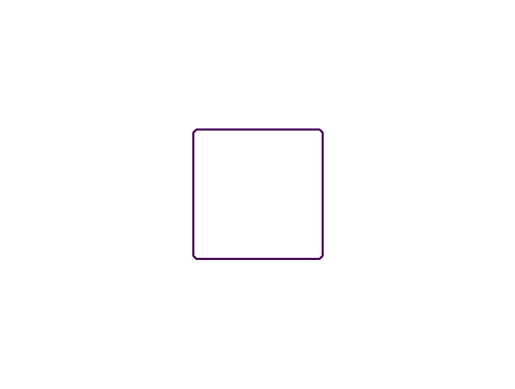

In [19]:
start=time.time()
grid_size = 64

fig = plt.figure()
x = gen_grid(grid_size,-2.0,2.0)

def animate(t):
    plt.cla()
    out = linear_morphing(sdf_box,sdf_pentagon,np.array([t]), x)
    #levels = np.linspace(-1.0, 1.0, 21)
    #im = plt.contourf(out.reshape(grid_size, grid_size), levels = levels)
    im = plt.contour(out.reshape(grid_size, grid_size), levels = [0.0])
    plt.axis('equal')
    plt.axis("off")
    return im

anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
end=time.time()
anim.save("linear_morphing.mp4", fps=20, writer="ffmpeg")
#anim = animation.FuncAnimation(fig, animate, frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())
#HTML(anim.to_html5_video())
files.download("linear_morphing.mp4")
print(end-start)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.012672901153564453


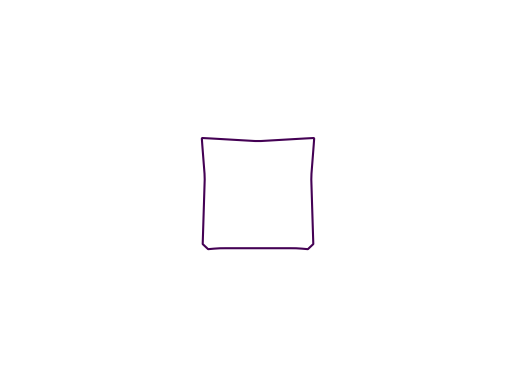

In [20]:
start=time.time()
grid_size = 64

fig = plt.figure()
x = gen_grid(grid_size, low=-2.0, high=2.0)

def animate(t):
    plt.cla()
    out = space_time_blending(sdf_box,sdf_pentagon,np.array([t]), x, a0=1.0, a1=1.0, a2=1.0)
    im = plt.contour(out.reshape(grid_size, grid_size), levels = [0.0])
    plt.axis('equal')
    plt.axis("off")
    return im
#space time blending
anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
end=time.time()
anim.save("stb_morphing_translated.mp4",fps=20, writer="ffmpeg")
files.download("stb_morphing_translated.mp4")
print(end-start)

(4096, 2)
(4096,)
(4096, 2)
(4096,)


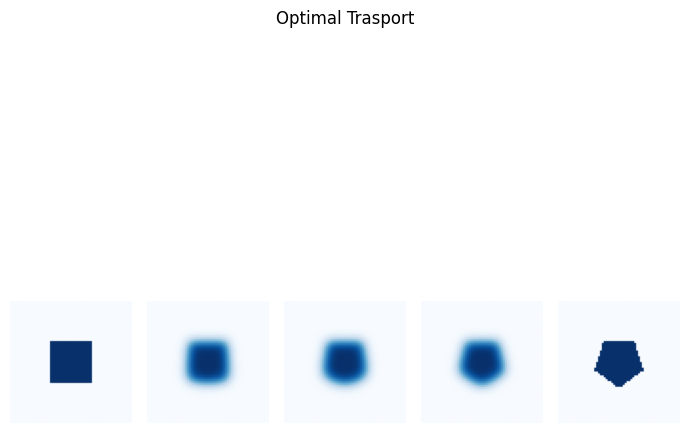

0.2892882823944092


In [24]:
start=time.time()
grid_size = 64
grid = gen_grid(grid_size,-2.0,2.0)

# f1 and f2 are prob. distribution corresponding to f1 and f2
f1 = sample_and_normalize(sdf_box, grid, grid_size)
f2 = sample_and_normalize(sdf_pentagon, grid, grid_size)

A = np.array([f1,f2])

nb_images = 5
reg = 0.004

v1 = np.array((1, 0))
v2 = np.array((0, 1))

fig, axes = plt.subplots(1, nb_images, figsize=(7, 7))
plt.suptitle("Optimal Trasport")
cm = "Blues"

for i in range(nb_images):
    tx = float(i) / (nb_images - 1)

    weights = (1 - tx) * v1 + tx * v2

    if i == 0:
        axes[i].imshow(f1, cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2, cmap=cm)
    else:
        # call to barycenter computation
        axes[i].imshow(
            ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm
        )
    axes[i].axis("off")
#Optimal Trasport
plt.tight_layout()
plt.show()
end=time.time()
print(end-start)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.003459930419921875


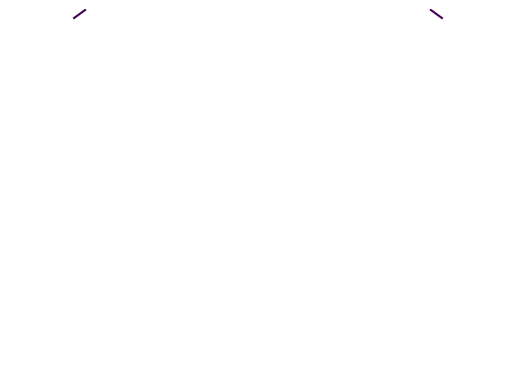

In [27]:
start=time.time()
grid_size = 64

fig = plt.figure()
x = gen_grid(grid_size, low=-2.0, high=2.0)

def animate(t):
    plt.cla()
    out = bounded_blending(sdf_box,sdf_pentagon,np.array([t]), x, a0=1.0, a1=1.0, a2=1.0)
    im = plt.contour(out.reshape(grid_size, grid_size), levels = [0.0])
    plt.axis('equal')
    plt.axis("off")
    return im
#bounded blending
anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
end=time.time()
anim.save("bd_morphing_translated.mp4",fps=20, writer="ffmpeg")
files.download("bd_morphing_translated.mp4")
print(end-start)